In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import pandas as pd

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [3]:
#overview of the data
DATA_FILE_PATH = os.path.join(os.getcwd(),'data','100_50')

dir_list = os.listdir(DATA_FILE_PATH)
max_data_points = len(dir_list)
print("Number of data points: {}".format(len(dir_list)))
print(dir_list[0])

data_x_columns = ['forces','supports','filled','x']
data_y_columns = ['x','finished']


Number of data points: 3123
Agent1_485135


<h1>Data information:</h1>

All the data will bes stored in a pandas data frame

Three primary datasets can be retreived from the data in the folder
<ul>
    <li>Iterative method data</li>
    <li>End to End data</li>
    <li>Compliance clasification data</li>
</ul>



In [4]:
def unpackLoadCondtions(loadConditions):
    forces = loadConditions['a']
    free = loadConditions['b']
    passive = loadConditions['c']
    formating_array = loadConditions['d']

    volfrac = formating_array[0]
    nelx = int(formating_array[1])
    nely = int(formating_array[2])
    penal = formating_array[3]
    rmin = formating_array[4]

    #print(volfrac,nelx,nely)

    return forces,free,passive,volfrac,nelx,nely,penal,rmin


def unpackIteration(iteration):
    x = iteration['a']
    xPhys = iteration['b']
    formating_array = iteration['c']

    compliance = formating_array[0]
    change = formating_array[1]
    mass = formating_array[2]

    #print(compliance,change,mass)
    return x,xPhys,compliance,change,mass

def getAgentData(agentPath):
    """
    Given a agent file path as a input, return all the unpacked and sorted data from that agent
    returns:
        forces,free,passive,volfrac,nelx,nely,penal,rmin,x_array,xPhys_array,compliance_array,change_array,mass_array
    """

    FilesToGrab = os.listdir(agentPath)
    numberOfIterations = len(FilesToGrab) - 1
    iterations = []

    loadConditionsExist = False


    for fileName in FilesToGrab:
        if('loadConditions' in fileName):
            loadConditions = np.load(os.path.join(agentPath,fileName))
            #print('loadCondtions Exist')
            loadConditionsExist = True
            
        elif('iteration_' in fileName):
            number_extension = fileName[len('iteration_'):]
            extesionIndex = number_extension.find('.')
            number = int(number_extension[:extesionIndex])
            #print(number)
            iterations.append([number,np.load(os.path.join(agentPath,fileName))])
        #print(fileName)
    
    if(not loadConditionsExist):
        raise Exception("File path {} does not hold propper data".format(agentPath))

    def sortKey(x):
        return x[0]

    iterations.sort(key=sortKey)
    #print(iterations)

    forces,free,passive,volfrac,nelx,nely,penal,rmin = unpackLoadCondtions(loadConditions)

    x_array = []
    xPhys_array = []
    compliance_array = []
    change_array = []
    mass_array = []

    for i in range(numberOfIterations):
        x,xPhys,compliance,change,mass = unpackIteration(iterations[i][1])
        x_array.append(x)
        xPhys_array.append(xPhys)
        compliance_array.append(compliance)
        change_array.append(change)
        mass_array.append(mass)

    return forces,free,passive,volfrac,nelx,nely,penal,rmin,x_array,xPhys_array,compliance_array,change_array,mass_array


    

The first dataset will be the iterative model.

This model will attempt to mimic the proccess of the TopOpt where a 'part' and load conditions will be inputed and then the optimal part will then be outputed. This new optimal part should in theory be able to be put back into the model untill it is fully optimized.

The model data will be formated as follows:
<h1>Inputs</h1>
<ul>
    <li>xphys:the part to be optimized</li>
    <li>forces: as an image for xforces and y forces</li>
    <li>Supports: as an image</li>
</ul>

<h1>Outputs</h1>
<ul>
    <li>x: the optimal part</li>
    <li> A boolean representing if the part has been fully optimized, i.e. last iteration</li>
</ul>

The data will be built with the following factors in mind.
<ol>
    <li>The output x will be an image of values between 0 and 1</li>
    <li>The boolean can be gotten using a cross entropy error and the wieght on the total accuracy will be low</li>
    <li>Since mass will need to remain constant, we can sum the first xphys input layer and use that to normalize the output x</li>
    <li>Forces will be an image of nelx+1 by nely+1 with two channels, supports will be the same size as forces but with one channel. xPhys will only be nelx by nely so some form of resizing may be needed</li>
    <li>It will be important for the model to know when the part is fully optimized, thus extra data of a fully optimized part as input and itself as output will be used to enforce the idea that there is an optimal end point</li>
    <li>A step/jump in iterations may be needed, this will make it so that instead of model predicting an iteration, it will predict 2 iterations in one go.</li>
</ol>

In [5]:
def formatIterativeModelDataSet(agentFilePath):
    """
    For the iterative model data.
    Takes the extensive output of the getAgentData function and returns the formated data needed for the iterateive model


    Forces, passive, and free must be rebuilt as propper images and not 1D arrays
    """
    forces,free,passive,_,nelx,nely,_,_,_,xPhys_array,_,_,_ = getAgentData(agentFilePath)
    # print("Forces shape",forces.shape)
    # print("free shape",free.shape)
    # print("passive shape",passive.shape)
    # print("xphys shape",xPhys_array[0].shape)


    finalShape = (int(nelx+1),int(nely+1))
    forces2 = forces.sum(1)
    forces2 = np.reshape(forces2,(finalShape[0],finalShape[1],2))

    d2 = np.ones(2*finalShape[0]*finalShape[1])
    for index in free:
        d2[index] = 0
    d3 = np.reshape(d2,(finalShape[0],finalShape[1],2))
    degreesOfFreedom2 = d3.sum(2)

    passive2 = np.zeros((nelx*nely))
    passive2 = np.where(passive > 0,1,0)
    passive2 = np.reshape(passive2,(nelx,nely))


    #reshape x_arrays as an np array
    numberOfIterations = len(xPhys_array)
    xPhys_np_array = np.zeros((nelx,nely,numberOfIterations))
    for i in range(numberOfIterations):
        xPhys_np_array[:,:,i] = np.reshape(xPhys_array[i],(nelx,nely))

    


    return forces2,degreesOfFreedom2,passive2,xPhys_np_array,numberOfIterations

def buildIterativeModelDataSet(dataPointsToGrab:int,iterationJump:int=1):
    # DATA_FILE_PATH = path to agent files
    # dir_List = all agent files
    # max_data_points = total number of datapoints

    dataPointsToGrab = min(dataPointsToGrab,max_data_points)

    #randomize the dataGrabed
    indexList = np.arange(max_data_points,dtype='int32')
    np.random.shuffle(indexList)

    dataX = []
    dataY = []
    print("Retreiving {} Datapoints.".format(dataPointsToGrab))

    for i in range(dataPointsToGrab):
        print("{}%\t\t".format(int(100*(i/dataPointsToGrab))),end='\r')
        try:
            forces,dof,passive,x,numIterations = formatIterativeModelDataSet(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]]))
        except:
            print("Exception Occured at file '{}'.".format(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])))
            continue
        else:
            # print("index:",indexList[i])
            # print("Forces shape:",forces.shape)
            # print("free shape:",dof.shape)
            # print("passive shape:",passive.shape)
            # print("xphys shape:",x.shape)
            #print("Out of {} iterations.".format(numIterations))
            for j in range(numIterations-iterationJump):
                dataX.append([forces.copy(),dof.copy(),passive.copy(),x[:,:,j]])
                v = 0.0
                f= 'unfinished'
                if(j+iterationJump >= numIterations - 1):
                    v = 1.0
                    f = 'finished'
                dataY.append([x[:,:,j+iterationJump],np.array([v])])

                #print("Adding itter: {} -> {}:{}".format(j,j+iterationJump,f))

            for j in range(1,min(iterationJump,numIterations)):
                # add the last iterations(dataY has True)
                dataX.append([forces.copy(),dof.copy(),passive.copy(),x[:,:,-j -1]])
                dataY.append([x[:,:,numIterations-1],np.array([1.])])

                #print("Adding itter: {} -> {}:finished".format(numIterations-j-1,numIterations-1))

            # add the optimal Stoping point data, input = output
            dataX.append([forces.copy(),dof.copy(),passive.copy(),x[:,:,numIterations-1]])
            dataY.append([x[:,:,numIterations-1],np.array([1.])])

        #print("Adding itter: {} -> {}:finished".format(numIterations-1,numIterations-1))
    print("100%\t\t")
    return dataX,dataY
        


In [6]:
def buildFirstIterationDataset(dataPointsToGrab:int):
    """
    Due to the lack of learning of the model when given all the data points, this data set seeks to tech it the first iteration, 
    the model will be given the atarting iteration 0 as input and then iteration 1 and 2  as output.
    """
    dataPointsToGrab = min(dataPointsToGrab,max_data_points)

    #randomize the dataGrabed
    indexList = np.arange(max_data_points,dtype='int32')
    np.random.shuffle(indexList)

    dataX = []
    dataY = []
    print("Retreiving {} Datapoints.".format(dataPointsToGrab))

    for i in range(dataPointsToGrab):
        print("{}%\t\t".format(int(100*(i/dataPointsToGrab))),end='\r')
        try:
            forces,dof,passive,x,numIterations = formatIterativeModelDataSet(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]]))
        except:
            print("Exception Occured at file '{}'.".format(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])))
        else:
            #add the 0th iteration as input and the 1st and 2nd iteration as output
            dataX.append([forces.copy(),dof.copy(),passive.copy(),x[:,:,0]])
            dataY.append([x[:,:,1],np.array([0.])])

            dataX.append([forces.copy(),dof.copy(),passive.copy(),x[:,:,0]])
            dataY.append([x[:,:,2],np.array([0.])])

        #print("Adding itter: {} -> {}:finished".format(numIterations-1,numIterations-1))
    print("100%\t\t")
    return dataX,dataY

    

In [7]:

#data_x,data_y = buildIterativeModelDataSet(500,10)
data_x,data_y = buildFirstIterationDataset(2000)
print("x:",len(data_x))
print("y:",len(data_y))

Retreiving 2000 Datapoints.
100%		
x: 4000
y: 4000


In [8]:
#Test Train Split
"""
By performing the test train split we can get a training data set and a testing dataset to get the metrics for out model
By performing the split a second time we can get a scoring dataset that the model will never see that we can use to get out own accuracy score out of
"""
X_train, X_test, Y_train, Y_test  = train_test_split(data_x,data_y, test_size=0.2)
X_test, X_score, Y_test, Y_score = train_test_split(X_test,Y_test, test_size=0.05)
print("X_train: {}\nY_train: {}".format(len(X_train), len(Y_train)))
print("\nX_test: {}\nY_test: {}".format(len(X_test), len(Y_test)))
print("\nX_score: {}\nY_score: {}".format(len(X_score), len(Y_score)))

X_train: 3200
Y_train: 3200

X_test: 760
Y_test: 760

X_score: 40
Y_score: 40


<h1>Model Information</h1>

Below are the models that will be used to attempt to learn the dataset

In [9]:
#universal parameters
activation = 'relu'
uniformRandomInitalizer = tf.random_uniform_initializer(minval=-0.5, maxval=0.5)

In [10]:
def model_m1(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    """
    A generic image creation model
    ['forces','supports','filled','x']

    Inputs:
        x: (100,50)
        forces: (101,51,2)
        supports: (101,51)
        filled: (100,50)

    Outputs:
        x: (100,50)
        done: bool
    """

    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")

    partConv = layers.Conv2D(filters= 5, kernel_size=(3,3),padding='same',activation=activation)(partInput)
    forceConv = layers.Conv2D(filters= 5, kernel_size=(3,3),padding='same',activation=activation)(forcesInput)
    supportConv = layers.Conv2D(filters= 5, kernel_size=(3,3),padding='same',activation=activation)(supportsInput)

    #resize the partConv to be the same as the rest of the data
    partConv = layers.ZeroPadding2D(padding=((1,0),(1,0)))(partConv)

    concatenatedConvolution = layers.Concatenate()([partConv,forceConv,supportConv])

    #First Convolution Layer
    x1 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(concatenatedConvolution)
    x1 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(x1)
    x2 = layers.MaxPooling2D(pool_size=(2,2))(x1)

    #Second convolution Layer
    x2 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(x2)
    x2 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(x2)
    x2 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(x2)
    x2 = layers.MaxPooling2D(pool_size=(2,2))(x2)

    #Dense 2D layer
    newShape = [x2.shape[1],x2.shape[2]]
    x3 = layers.Flatten()(x2)

    #upscaleLayer
    #upscaling is performed by convolution transpose where stride < kernalsize
    x4 = layers.Conv2DTranspose(filters= 16, kernel_size=(3,3),strides=2,padding='same',activation=activation)(x2)
    x4 = layers.Conv2DTranspose(filters= 16, kernel_size=(3,3),strides=2,padding='same',activation=activation)(x4)
    paddingNeeded = ((filledInput.shape[1]-x4.shape[1],0),(filledInput.shape[2]-x4.shape[2],0))

    x4 = layers.ZeroPadding2D(padding=paddingNeeded)(x4)
    filledAreaAddition = layers.Concatenate()([x4,filledInput])
    output_part = layers.Conv2D(filters= 1, kernel_size=(5,5),padding='same',activation=activation, name="x_out")(filledAreaAddition)

    #output for finished part

    x5 = layers.Dense(newShape[1],activation=activation)(x3)
    x5 = layers.Dense(20,activation=activation)(x5)
    output_finished =layers.Dense(1,activation='sigmoid', name="finished")(x5)

    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part,output_finished])


In [11]:
def model_m2(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    """
    A generic image creation model
    ['forces','supports','filled','x']

    Inputs:
        x: (100,50)
        forces: (101,51,2)
        supports: (101,51)
        filled: (100,50)

    Outputs:
        x: (100,50)
        done: bool
    """

    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")

    partConv = layers.Conv2D(filters= 5, kernel_size=(3,3),padding='same',activation=activation)(partInput)
    forceConv = layers.Conv2D(filters= 5, kernel_size=(3,3),padding='same',activation=activation)(forcesInput)
    supportConv = layers.Conv2D(filters= 5, kernel_size=(3,3),padding='same',activation=activation)(supportsInput)

    #resize the partConv to be the same as the rest of the data
    partConv = layers.ZeroPadding2D(padding=((1,0),(1,0)))(partConv)

    concatenatedConvolution = layers.Concatenate()([partConv,forceConv,supportConv])

    #First Convolution Layer
    x1 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(concatenatedConvolution)
    x1 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(x1)
    x1 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(x1)
    x2 = layers.MaxPooling2D(pool_size=(2,2))(x1)

    #Second convolution Layer
    x2 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(x2)
    x2 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(x2)
    x2 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(x2)
    x2 = layers.MaxPooling2D(pool_size=(2,2))(x2)

    #Dense 2D layer
    newShape = [x2.shape[1],x2.shape[2]]
    x3 = layers.Flatten()(x2)

    #upscaleLayer
    #upscaling is performed by convolution transpose where stride < kernalsize
    x4 = layers.Conv2DTranspose(filters= 16, kernel_size=(3,3),strides=2,padding='same',activation=activation)(x2)
    x4 = layers.Conv2DTranspose(filters= 16, kernel_size=(3,3),strides=2,padding='same',activation=activation)(x4)
    paddingNeeded = ((filledInput.shape[1]-x4.shape[1],0),(filledInput.shape[2]-x4.shape[2],0))

    x4 = layers.ZeroPadding2D(padding=paddingNeeded)(x4)
    filledAreaAddition = layers.Concatenate()([x4,filledInput])
    filledAreaAddition = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(filledAreaAddition)
    output_part = layers.Conv2D(filters= 1, kernel_size=(3,3),padding='same',activation=activation, name="x_out")(filledAreaAddition)

    #output for finished part

    x5 = layers.Dense(20,activation=activation)(x3)
    x5 = layers.Dense(20,activation=activation)(x5)
    output_finished =layers.Dense(1,activation='sigmoid', name="finished")(x5)

    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part,output_finished])


In [12]:
def SetUpOptimizer(variant):
    """
    Builds a keras optmizer based of default parameters
    
    Accepts:
        1:adam
        2:adadelta
        3:adafactor
        4:adagrad
        5:adamax
        6:ftrl
        7:nadam
        8:rmsprop
    """
    if(variant == 1 or variant == 'adam'):
        print("Optimizer: Adam")
        return keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 
    elif(variant == 2 or variant == 'adadelta'):
        print("Optimizer: AdaDelta")
        return keras.optimizers.experimental.Adadelta(
                                                        learning_rate=0.001,
                                                        rho=0.95,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adadelta'
                                                    )
    elif(variant == 3 or variant == 'adafactor'):
        print("Optimizer: AdaFactor")
        return keras.optimizers.experimental.Adafactor(
                                                        learning_rate=0.001,
                                                        beta_2_decay=-0.8,
                                                        epsilon_1=1e-30,
                                                        epsilon_2=0.001,
                                                        clip_threshold=1.0,
                                                        ema_momentum=0.99,
                                                        name='Adafactor'
                                                    )
    elif(variant == 4 or variant == 'adagrad'):
        print("Optimizer: AdaGrad")
        return keras.optimizers.experimental.Adagrad(
                                                        learning_rate=0.001,
                                                        initial_accumulator_value=0.1,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adagrad'
                                                    )
    elif(variant == 5 or variant == 'adamax'):
        print("Optimizer: AdaMax")
        return keras.optimizers.experimental.Adamax(
                                                        learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adamax'
                                                    )
    elif(variant == 6 or variant == 'ftrl'):
        print("Optimizer: FTRL")
        return keras.optimizers.experimental.Ftrl(
                                                    learning_rate=0.001,
                                                    learning_rate_power=-0.5,
                                                    initial_accumulator_value=0.1,
                                                    l1_regularization_strength=0.0,
                                                    l2_regularization_strength=0.0,
                                                    l2_shrinkage_regularization_strength=0.0,
                                                    beta=0.0,
                                                    ema_momentum=0.99,
                                                    name='Ftrl'
                                                )
    elif(variant == 7 or variant == 'nadam'):
        print("Optimizer: Nadam")
        return keras.optimizers.experimental.Nadam(
                                                    learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    ema_momentum=0.99,
                                                    name='Nadam'
                                                )
    elif(variant == 8 or variant == 'rmsprop'):
        print("Optimizer: RMSprop")
        return keras.optimizers.experimental.RMSprop(
                                                        learning_rate=0.001,
                                                        rho=0.9,
                                                        momentum=0.0,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        ema_overwrite_frequency=100,
                                                        name='RMSprop'
                                                    )
    else:
        print("Optimizer: Adam")
        return keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 

In [13]:
#setUp modelSaving

def getModel(modelNumber,optimizerVarient:int = 1):
    if(modelNumber == 1):
        model = model_m1()
        fileSaveName = "Model_m1"
        
    elif(modelNumber == 2):
        model = model_m2()
        fileSaveName = "Model_m2"
    else:
        raise Exception("No model identified, model {} DNE.".format(modelNumber))
    

    modelPath = os.path.join(os.getcwd(),'ModelSave',fileSaveName)
    
    cp_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelPath,fileSaveName),
                                                     save_weights_only=True,
                                                     verbose=1)
    if(os.path.isdir(modelPath)):
        model.load_weights(os.path.join(modelPath,fileSaveName))
    else:
        os.mkdir(modelPath)

    if(modelNumber == 1 or modelNumber == 2):
        model.compile(optimizer=SetUpOptimizer(optimizerVarient),
                        loss={
                            'x_out':keras.losses.MeanSquaredLogarithmicError(), #logrithmic error for the 0-1 output of the image
                            'finished':keras.losses.BinaryCrossentropy(from_logits=True) #binary entropy error for the bool output
                        },
                        loss_weights={'x_out':1.0,'finished':0.01})
    
    return model,cp_callback

In [14]:
model,callBack = getModel(2)
model.summary()

Optimizer: Adam
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x (InputLayer)                 [(None, 100, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 50, 5)   50          ['x[0][0]']                      
                                                                                                  
 forces (InputLayer)            [(None, 101, 51, 2)  0           []                               
                                ]                                                                 
                                                                              

In [15]:
#data spliting
def splitX(data):
    forces_array = []
    support_array = []
    filled_array = []
    x_array = []
    for forces,support,filled,x in data:
        forces_array.append(forces)
        support_array.append(support)
        filled_array.append(filled)
        x_array.append(x)
    return x_array,filled_array,forces_array, support_array,  

def splitY(data):
    x_array = []
    finished_array = []
    for x,finished in data:
        x_array.append(x)
        finished_array.append(finished)
    return x_array,finished_array

X_train_part, X_train_filled, X_train_forces, X_train_supports = splitX(X_train)
Y_train_x, Y_train_finished = splitY(Y_train)
X_test_part, X_test_filled, X_test_forces, X_test_supports = splitX(X_test)
Y_test_x, Y_test_finished = splitY(Y_test)


X_train_part = np.array(X_train_part)
X_train_forces = np.array(X_train_forces)
X_train_supports = np.array(X_train_supports)
X_train_filled = np.array(X_train_filled)
Y_train_x = np.array(Y_train_x)
Y_train_finished = np.array(Y_train_finished)

X_test_part = np.array(X_test_part)
X_test_forces = np.array(X_test_forces)
X_test_supports = np.array(X_test_supports)
X_test_filled = np.array(X_test_filled)
Y_test_x = np.array(Y_test_x)
Y_test_finished = np.array(Y_test_finished)

print(len(X_train_part))


3200


In [16]:
BatchSize = 32 # default tensorflow batchsize
numEpochs = 10
BatchesPerEpoch = len(X_train_part) // (BatchSize*numEpochs)
BatchesPerEpoch = BatchesPerEpoch

print(BatchesPerEpoch)


20


In [17]:

history = model.fit(
        {'x':X_train_part,'forces':X_train_forces,'supports':X_train_supports,'filled':X_train_filled},
        {'x_out':Y_train_x,'finished':Y_train_finished},
        batch_size=None,#BatchSize,
        epochs=numEpochs,
        shuffle=True,
        validation_data=(
                        {'x':X_test_part,'forces':X_test_forces,'supports':X_test_supports,'filled':X_test_filled},
                        {'x_out':Y_test_x,'finished':Y_test_finished}),
        callbacks=[callBack],
        steps_per_epoch = None)#BatchesPerEpoch)

Epoch 1/5


c:\Users\Nate\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend.py:5674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


100/100 [==============================] - ETA: 0s - loss: 0.0324 - x_out_loss: 0.0322 - finished_loss: 0.0251
Epoch 1: saving model to c:\Users\Nate\Documents\GitHub\SOundstuff\Top-Op\MachineLerning\ModelSave\Model_m2\Model_m2
100/100 [==============================] - 573s 6s/step - loss: 0.0324 - x_out_loss: 0.0322 - finished_loss: 0.0251 - val_loss: 0.0171 - val_x_out_loss: 0.0171 - val_finished_loss: 2.1140e-07
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.0162 - x_out_loss: 0.0162 - finished_loss: 3.6735e-07
Epoch 2: saving model to c:\Users\Nate\Documents\GitHub\SOundstuff\Top-Op\MachineLerning\ModelSave\Model_m2\Model_m2
100/100 [==============================] - 539s 5s/step - loss: 0.0162 - x_out_loss: 0.0162 - finished_loss: 3.6735e-07 - val_loss: 0.0153 - val_x_out_loss: 0.0153 - val_finished_loss: 4.7353e-07
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.0148 - x_out_loss: 0.0148 - finished_loss: 2.3343e-06
Epoch 3: saving m

In [19]:
#build some statistics on the data
X_score_part, X_score_filled, X_score_forces, X_score_supports = splitX(X_score)
Y_score_x, Y_score_finished = splitY(Y_score)

X_score_part = np.array(X_score_part)
X_score_forces = np.array(X_score_forces)
X_score_supports = np.array(X_score_supports)
X_score_filled = np.array(X_score_filled)
Y_score_x = np.array(Y_score_x)
Y_score_finished = np.array(Y_score_finished)

output = model.predict({'x':X_score_part,'forces':X_score_forces,'supports':X_score_supports,'filled':X_score_filled})
Y_pred_part = output[0]
Y_pred_finished = output[1]
print(len(Y_pred_part))


2/2 [==============================] - 2s 489ms/step
40


In [ ]:
def finalBit(a):
    if(a[0] > 0):
        return 'fin'
    else:
        return 'it.'

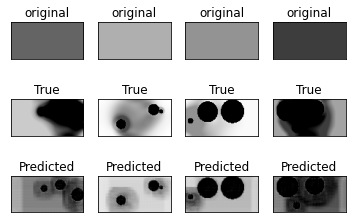

In [21]:
#plot the true and predicted Values
ncol = 4
nelx = 100
nely = 50

fig,ax = plt.subplots(3,ncol)

rnd = np.arange(len(X_score_part),dtype='int32')
np.random.shuffle(rnd)

for i in range(ncol):
    ax[0,i].set_title("original")
    ax[0,i].imshow(np.reshape(X_score_part[rnd[i]],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    ax[1,i].set_title("True")#:{}".format(finalBit(Y_score_finished[rnd[i]])))
    ax[1,i].imshow(np.reshape(Y_score_x[rnd[i]],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

    ax[2,i].set_title("Predicted")#:{}".format(finalBit(Y_pred_finished[rnd[i]])))
    ax[2,i].imshow(np.reshape(Y_pred_part[rnd[i]],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

plt.show()




<h1>Thoughts</h1>

The model is not learning anything. It is applying a blur filter to what it is given and adding the circles around that. I think that a new aproach it needed to fully train the model.

In addition to various different loss functions and optimizers that could be changed, and can easily be changed. I think that training the model on only the first itteration of each data point may be a good indicator of how things should end up.

By looking only at the first itteration, the model learn how to form shapes between the given points instead of just adding a blur. The first iteration being the solid volume filled with the volfrac amount and the optimal part from that being the first signs of a shape forming

Since the x data is a float between 0 and 1 I think that it may be nessesary to cosider a different loss function. logrithmic error is good for this type of loss but there may be a better loss function for the part data.

Looking at the model outputs, we need to introduce the circles eariler as well as ensure taht the convolutions allow for a full grasp of what the part is. As much as I didn't want to a fully dense or perhaps a few fully dense layers are needed.